In [15]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os
import numpy as np
from face_alignment import FaceAlignment, LandmarksType
from torchvision import transforms
import PIL
import matplotlib.pyplot as plt
import random

from processVoxCelDataset import *

In [16]:
class metaTrainVideoDataset(Dataset):
    def __init__(self, K, rootDir, outputDir, randomFrame, device='gpu', transform=None):
        '''

        :param K:
        :param rootDir: root directory of the video files
        :param outputDir: output directory for generated landmarks
        :param randomSeed: if none
        :param device:
        :param transform:
        '''
        self.K = K
        self.rootDir = rootDir
        self.outputDir = outputDir
        self.randomFrame = randomFrame
        self.device = device
        self.transform = transform

        self.videoList = generateVideoList(rootDir)
        self.fa = FaceAlignment(LandmarksType._2D, device=device)

    def __len__(self):
        return len(self.videoList)

    def __getitem__(self, idx):
        # get K+1 frames, K for embedder; 1 for generator
        data = generateKSelectedFramesAndLandmarksForSpecificVideo(self.K + 1, self.videoList[idx], self.outputDir,
                                                                   self.fa, self.randomFrame)
        
        if(self.randomFrame):
            random.shuffle(data)

        data_array = []
        for d in data:
            frame = PIL.Image.fromarray(d['frame'], 'RGB')  # [H, W, 3]
            landmarks = PIL.Image.fromarray(d['landmarks'], 'RGB')  # [H, W, 3]
            if self.transform:
                frame = self.transform(frame)  # [3, H, W]
                landmarks = self.transform(landmarks)  # [3, H, W]
            assert torch.is_tensor(frame), "The source images must be converted to Tensors."
            assert torch.is_tensor(landmarks), "The source landmarks must be converted to Tensors."
            data_array.append(torch.stack((frame, landmarks)))  # [2, 3, H, W]
        data_array = torch.stack(data_array)  # [K+1, 2, 3, H, W]

        return idx, data_array


In [46]:
dataset = metaTrainVideoDataset(
    K = 8,
    rootDir = '../data/train/mp4/',
    outputDir = '../data/train/output/', 
    randomFrame = True,
    device = 'cpu',
    transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
        ])
    )

dataLoader = DataLoader(dataset, batch_size=2, shuffle=False)

In [47]:
idx, data_array = dataset[0]

In [48]:
idxBatch, landmarkFramesBatch = next(iter(dataLoader))

In [49]:
len(dataLoader)

484

In [50]:
idx

0

In [51]:
landmarkFramesBatch.shape

torch.Size([2, 9, 2, 3, 256, 256])

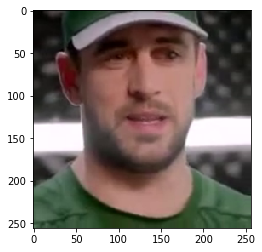

In [52]:
plt.imshow(landmarkFramesBatch[0, 2, 0].permute(1, 2, 0))